In [1]:
import sys; sys.path.append(".")

%reload_ext autoreload
%autoreload 2

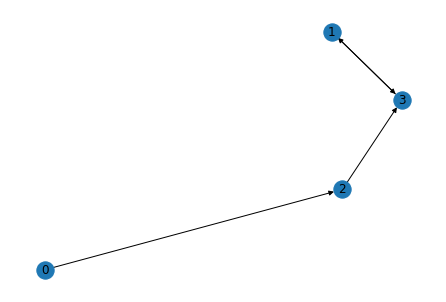

In [2]:
import networkx as nx

in_degrees = [0, 1, 1, 2]
out_degrees = [1, 1, 1, 1]
nkk = {1: {1: 2, 2: 2}}
G = nx.directed_joint_degree_graph(in_degrees, out_degrees, nkk)
nx.draw(G, with_labels=True)

In [3]:
import networkx as nx

def twitter():
    G = nx.DiGraph()
    with open("twitter.txt", "r") as lines:
        for line in lines:
            a, b = line.split()
            G.add_edge(int(a), int(b))
    return G

G = twitter()

In [9]:
from random import choice, random
from tabulate import tabulate

start = choice(list(G.nodes()))

RETWEET_PROB = 0.04

S = list()
S.append(start)
visited = set()

while S:
    curr = S.pop()

    if curr in visited:
        continue

    visited.add(curr)
    neighbors = list(G.neighbors(curr))
    for neighbor in neighbors:
        if random() < RETWEET_PROB:
            S.append(neighbor)

N = G.number_of_nodes()
V = len(visited)
print(
    tabulate(
        [
            ["RETWEET PROBABILITY", RETWEET_PROB],
            ["N", N],
            ["V", V],
            ["CASCADE SIZE (V / N)", round(V / N, 2)],
        ],
        tablefmt="fancy_grid",
        numalign="left",
    )
)

╒══════════════════════╤═══════╕
│ RETWEET PROBABILITY  │ 0.04  │
├──────────────────────┼───────┤
│ N                    │ 81306 │
├──────────────────────┼───────┤
│ V                    │ 15399 │
├──────────────────────┼───────┤
│ CASCADE SIZE (V / N) │ 0.19  │
╘══════════════════════╧═══════╛


In [42]:
def joint_degree_distribution(G):
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.out_degree(edge[0])
        in_deg = G.in_degree(edge[1])
        if (out_deg in outer_dict):
            if (in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] += 1
            else:
                outer_dict[out_deg][in_deg] = 1
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 1
    return outer_dict
    
jdd = joint_degree_distribution(G)


In [77]:
18 // 20

0

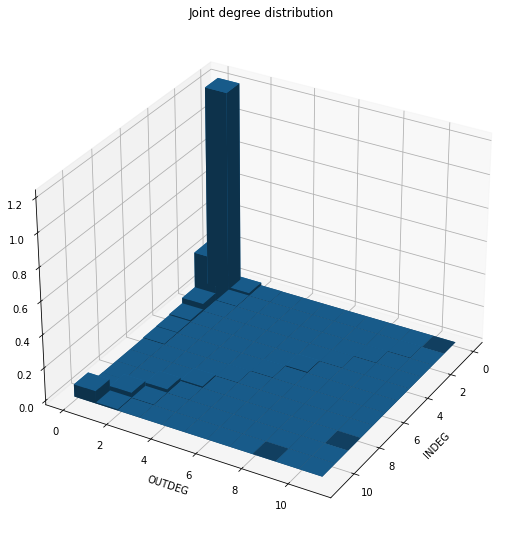

In [86]:
import numpy as np
import matplotlib.pyplot as plt

max_in = max(list(map(lambda x: x[1], G.in_degree(G.nodes))))
max_out = max(list(map(lambda x: x[1], G.out_degree(G.nodes))))
max_in, max_out

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')

size = 30
x_step = max_in // size
y_step = max_out // size
_x = np.arange(size + 1)
_y = np.arange(size + 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
ax.set_xlabel("INDEG")
ax.set_ylabel("OUTDEG")

z = np.zeros_like(x)
for i in jdd.keys():
    t = jdd[i]
    for key, val in jdd[i].items():
        a = i // y_step
        b = key // x_step
        z[a + b * size] += val

bottom = np.zeros_like(z)
width = depth = 1

ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title("Joint degree distribution")
ax.azim = 30

plt.show()

Od tu naprej irrelevant

In [61]:
x = [] 
y = []
z = []

for out_key, out_value in jdd.items():
    for in_key, in_value in jdd[out_key].items():
        x.append(out_value)
        y.append(in_value)
        z.append(jdd[out_key][in_key])

print(x)
print(y)
print(z)

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def inter_hist(ivls, n_bins = 10):
    imin, imax = ivls.min(), ivls.max()
    values = np.arange(imin,imax+1)
    counts = np.zeros(values.shape)
    for i,j in (ivls-imin): 
        counts[i:j+1] += 1
 
    bins = np.arange(imin, imax+1, ((imax-imin)/n_bins))
    plt.hist(values, bins, weights=counts)

intervals = np.array([x,y,z])
inter_hist(intervals)

ValueError: too many values to unpack (expected 2)

In [ ]:
x = [] 
y = []
z = []

for i in range(len(jdd)):
    if (i in jdd):
        x.append()

TypeError: float() argument must be a string or a number, not 'dict'

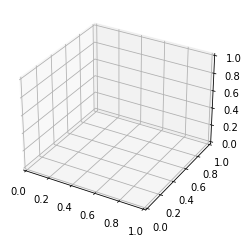

In [56]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='y', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

ValueError: cannot reshape array of size 154911 into shape (3383,1205)

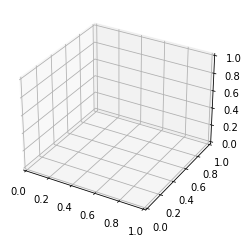

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# setup the figure and axes
#fig = plt.figure(figsize=(8, 3))
#ax1 = fig.add_subplot(121, projection='3d')
#ax2 = fig.add_subplot(122, projection='3d')

# fake data
'''
_x = np.arange(3383)
_y = np.arange(1205)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.reshape(x, (3383, 1205))
y = np.reshape(y, (3383, 1205))
z = np.reshape(z, (3383, 1205))

ax.plot_surface(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()